In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import math
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import tensorflow_hub as hub

In [2]:
img_height = img_width = 224
batch_size = 10

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_gen = test_datagen.flow_from_directory(
    "data2019/test/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    classes=['Actinic Keratosis', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Melanocytic Nevus', 'Melanoma', 'Squamous Cell Carcinoma', 'Vascular Lesion'],
    shuffle=False,
    seed=100,
)

Found 2555 images belonging to 8 classes.


In [3]:
resnet_model = load_model('models/resnet.h5', custom_objects={'KerasLayer':hub.KerasLayer})
nasnet_model = load_model('models/nasnet.h5', custom_objects={'KerasLayer':hub.KerasLayer})
efficientnet_model = load_model('models/efficientnet.h5', custom_objects={'KerasLayer':hub.KerasLayer})

#adding the models to a list
models = list()
models.append(resnet_model)
models.append(nasnet_model)
models.append(efficientnet_model)

In [4]:
#evaluating on the test batch
print(resnet_model.evaluate(x=test_gen))
print(nasnet_model.evaluate(x=test_gen))
print(efficientnet_model.evaluate(x=test_gen))

256/256 [==============================] - 35s 136ms/step - loss: 1.0357 - accuracy: 0.8149
[1.0357141494750977, 0.8148728013038635]
256/256 [==============================] - 34s 133ms/step - loss: 11.7190 - accuracy: 0.1049
[11.719029426574707, 0.10489236563444138]
256/256 [==============================] - 34s 134ms/step - loss: 1.5607 - accuracy: 0.5601
[1.560654640197754, 0.5600782632827759]


In [5]:
# make predictions
model_pred = [model.predict(test_gen) for model in models]
model_pred = np.array(model_pred)

# sum across ensembles
probability_sum = np.sum(model_pred, axis=0)

# argmax across classes
predictions = np.argmax(probability_sum, axis=-1)

#https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/
#Used this source for help

In [39]:
print(predictions)

[5 2 5 ... 7 7 7]


Confusion matrix without normalization
[[  25   16   13    0    0   19    4    1]
 [   3  257   24    2   16   34    3    4]
 [   3   20  171    1   24   38    2    2]
 [   0    1    3    7    4    4    0    0]
 [   1   27   73   10 1079  120    0    8]
 [   1   21   43    1   58  319    3    5]
 [   2   11   12    0    0   15   18    1]
 [   0    2    2    1    2    3    0   16]]


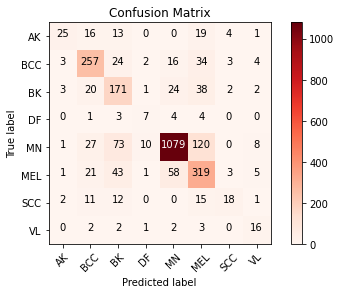

In [6]:
cm = confusion_matrix(y_true=test_gen.classes, y_pred=predictions)

#function for confusion matrix taken from scikit-learn website
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['AK', 'BCC', 'BK', 'DF', 'MN', 'MEL', 'SCC', 'VL'] #setting labels
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [7]:
print(accuracy_score(test_gen.classes, predictions))

0.7405088062622309


In [10]:
from sklearn.metrics import classification_report

#this gives precision, recall, f1 score and accuracy scores
print(classification_report(test_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.71      0.32      0.44        78
           1       0.72      0.75      0.74       343
           2       0.50      0.66      0.57       261
           3       0.32      0.37      0.34        19
           4       0.91      0.82      0.86      1318
           5       0.58      0.71      0.64       451
           6       0.60      0.31      0.40        59
           7       0.43      0.62      0.51        26

    accuracy                           0.74      2555
   macro avg       0.60      0.57      0.56      2555
weighted avg       0.76      0.74      0.74      2555



In [ ]:
#print(test_labels)
test_gen.class_indices